---


# **CLUSTERING**


This assignment aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering and explore the impact of PCA on these clustering techniques.

---
**Dataset Path:** "Data/wholesale_customers_data.csv"
---

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

***Variables***

* FRESH: annual spending (m.u.) on fresh products (Continuous);
* MILK: annual spending (m.u.) on milk products (Continuous);
* GROCERY: annual spending (m.u.)on grocery products (Continuous);
* FROZEN: annual spending (m.u.)on frozen products (Continuous)
* DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
* DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
* CHANNEL: customers Channel - (Hotel/Restaurant/Cafe) (Nominal)
* REGION: customers Region  (Lisnon, Oporto or Other) (Nominal)




# **Necessary Imports**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# **Necessary Functions**

In [ ]:
#Calculte the outer or inner fences for outlier identification
#dataframe: The dataframe to be used
#feature: The specific feature to look up the outliers
#coef: The coefficient to specify the type of the fence; 1.5 for inner fences and 3 for outer fences
#return:  The lower and upper values of the fences in a list
def calculate_fence(dataframe: pd.DataFrame, feature: str, coef: int) -> list:
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    fences = [Q1 - coef*IQR, Q3 + coef*IQR]
    return fences

def detect_outliers(dataframe: pd.DataFrame, columns: list, display=False) -> None:
    for column in columns:
        inner_fence = calculate_fence(dataframe, column, 1.5)
        outer_fence = calculate_fence(dataframe, column, 3)
        
        mild_outliers = dataframe[((dataframe[column] < inner_fence[0]) & (dataframe[column] >= outer_fence[0])) |
                                    ((dataframe[column] > inner_fence[1]) & (dataframe[column] <= outer_fence[1]))]
        extreme_outliers = dataframe[(dataframe[column] < outer_fence[0]) | (dataframe[column] > outer_fence[1])]
        dataframe[f'{column}_extreme'] = (dataframe[column] < outer_fence[0]) | (dataframe[column] > outer_fence[1])
        if(display):
            print(column, inner_fence, outer_fence)
            print(f"The {column} product has {mild_outliers.shape[0]} mild outliers and {extreme_outliers.shape[0]} extreme outliers\n")

#To visualize different plots of some data in a dataset
#dataframe: pandas dataframe to use as a dataset
#features: array of strings; features to plot
#type: string; the type of visualization
#info: information to be used such as labels. [(figure_width, figure_height), figure_title, x_label, y_label]
#rotate: boolean; to rotate the xticks 30 degrees
def visualize(dataframe: pd.DataFrame, features: list, type: str, info=[(10,5), "", "", ""], rotate=False, n_cols=2, h_space=0.5, target="") -> None:
    sns.set_theme(style="whitegrid")
    n_features = len(features)
    fig, axes = plt.subplots((n_features + n_cols - 1) // n_cols, n_cols, figsize=info[0])
    if n_cols == 1 or (n_features == 1 and n_cols == 1):
        axes = np.array([axes])
    axes = axes.flatten()
    for index, feature in enumerate(features):
        ax = axes[index]
        if(type == "histplot"):
            sns.histplot(dataframe[feature], bins=20, alpha=0.7, kde=True, ax=ax)
        elif(type=="scatterfit"):
            sns.regplot(x=feature, y=info[3], data=df_missing, ax=ax)
        elif(type=="scatter"):
            sns.scatterplot(data=dataframe, x=feature, y=target, ax=ax)
        elif(type=="countplot"):
            sns.countplot(data=dataframe, x=feature, alpha=0.7, ax=ax)
        elif(type=="boxplot"):
            sns.boxplot(x=dataframe[feature], ax=ax)
            inner_fence = calculate_fence(dataframe, feature, 1.5)
            outer_fence = calculate_fence(dataframe, feature, 3)
            ax.axvline(inner_fence[0], color='teal', linestyle='--', label='Inner Fence (Lower)')
            ax.axvline(inner_fence[1], color='teal', linestyle='--', label='Inner Fence (Upper)')
            ax.axvline(outer_fence[0], color='orange', linestyle='--', label='Outer Fence (Lower)')
            ax.axvline(outer_fence[1], color='orange', linestyle='--', label='Outer Fence (Upper)')
            #ax.legend()
        ax.set_title(feature)
        ax.set_xlabel(info[2])
        if(rotate):
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        ax.set_ylabel(info[3])
        sns.despine(ax=ax)
    if(n_features % 2 != 0 and n_cols % 2 == 0): #To remove unused subplots
        fig.delaxes(axes[n_features])
    fig.suptitle(info[1])
    plt.subplots_adjust(wspace=0.3, hspace=h_space)
    plt.show()

# **PART- 1: Data Preprocessing and Visualization**

---

## 1.1. Explaratory Data Analysis

* Dataset analyzed and analysis results explained
* Missing values and outliers checked and handled
* Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.



In [3]:
# your code here
df = pd.read_csv("Data/wholesale_customers_data.csv")

In [4]:
df.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

This dataset presents customers(Channel), which are Hotels, restaurants, or cafes, and their corresponding purchases. The customer purchase values are presented in the rows while the product categories are organized in their corresponding columns (Fresh, Milk, ...)
These customers also come from different regions presented in the Region column.
This dataset is clearly a clustering application dataset to identify the types and frequency of purchases for future recommendations or potential directed advertismenet.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [7]:
columns = df.columns
for column in columns:
    print(df[column].value_counts(), "\n\n")

Channel
1    298
2    142
Name: count, dtype: int64 


Region
3    316
1     77
2     47
Name: count, dtype: int64 


Fresh
9670     2
3        2
18044    2
8040     2
514      2
        ..
18827    1
10405    1
37036    1
30379    1
2787     1
Name: count, Length: 433, dtype: int64 


Milk
3045     2
1610     2
5139     2
2428     2
3587     2
        ..
1596     1
7152     1
13252    1
4280     1
1698     1
Name: count, Length: 421, dtype: int64 


Grocery
1664    2
2062    2
683     2
3600    2
6536    2
       ..
7305    1
3343    1
5034    1
8282    1
2510    1
Name: count, Length: 430, dtype: int64 


Frozen
2540    2
425     2
1285    2
4324    2
1619    2
       ..
2995    1
321     1
2279    1
825     1
65      1
Name: count, Length: 426, dtype: int64 


Detergents_Paper
118    2
955    2
256    2
69     2
918    2
      ..
516    1
399    1
51     1
960    1
477    1
Name: count, Length: 417, dtype: int64 


Delicassen
3       4
834     4
548     3
610     3
395     3
       

- No missing values.
- No special values indicating missing values.

In [8]:
df.iloc[:, :2].describe()

Channel      Region
count  440.000000  440.000000
mean     1.322727    2.543182
std      0.468052    0.774272
min      1.000000    1.000000
25%      1.000000    2.000000
50%      1.000000    3.000000
75%      2.000000    3.000000
max      2.000000    3.000000

In [9]:
df.iloc[:, 2:].describe()

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

In [10]:
print("Fresh:", df[df["Fresh"] > 16933].shape)
print("Milk:", df[df["Milk"] > 7190].shape)
print("Grocery:", df[df["Grocery"] > 10655].shape)
print("Frozen:", df[df["Frozen"] > 3554].shape)
print("Detergents_Paper:", df[df["Detergents_Paper"] > 3922].shape)
print("Delicassen:", df[df["Delicassen"] > 1820].shape)

Fresh: (110, 8)
Milk: (110, 8)
Grocery: (110, 8)
Frozen: (110, 8)
Detergents_Paper: (110, 8)
Delicassen: (110, 8)


#### Descriptive Table Analysis:

**Continous Variables:**
- For all variables, the mean is higher than the median. This suggests a positive skewness in the data. There are customers who spend a lot of resources(monetary units) on buying these products.
- **Every product** exhibit a high mean value and a high standard deviation suggesting that some customers are highly interested in getting these products. About 110 out of 440 customers are above the 75% percentile.
- The highest spends are on these products: **Fresh, Grocery, Milk, and Frozen.**
- There are not as much spends on these products: **Detergents_Paper, Delicassen.**
- The maximum values are very far from the mean and the 75% percentile suggesting some outliers in all features.

**Categorical Variables:**
- **The identification of the nominal variables was from the UCI Machine Learning Respository.**
  - **Two distinct channels: Horeca 298 - Retail 142. Horeca is an acronym that stands for Hotel, Restaurant, and Café/Catering.**
  - **Three distinct regions: Lisbon 77 - Oporto 47 - Other region 316**
- There are two channels with the first channel dominating the dataset. The second channel only occupies 32% of the whole observations.

#### Outlier Detection & Handling:

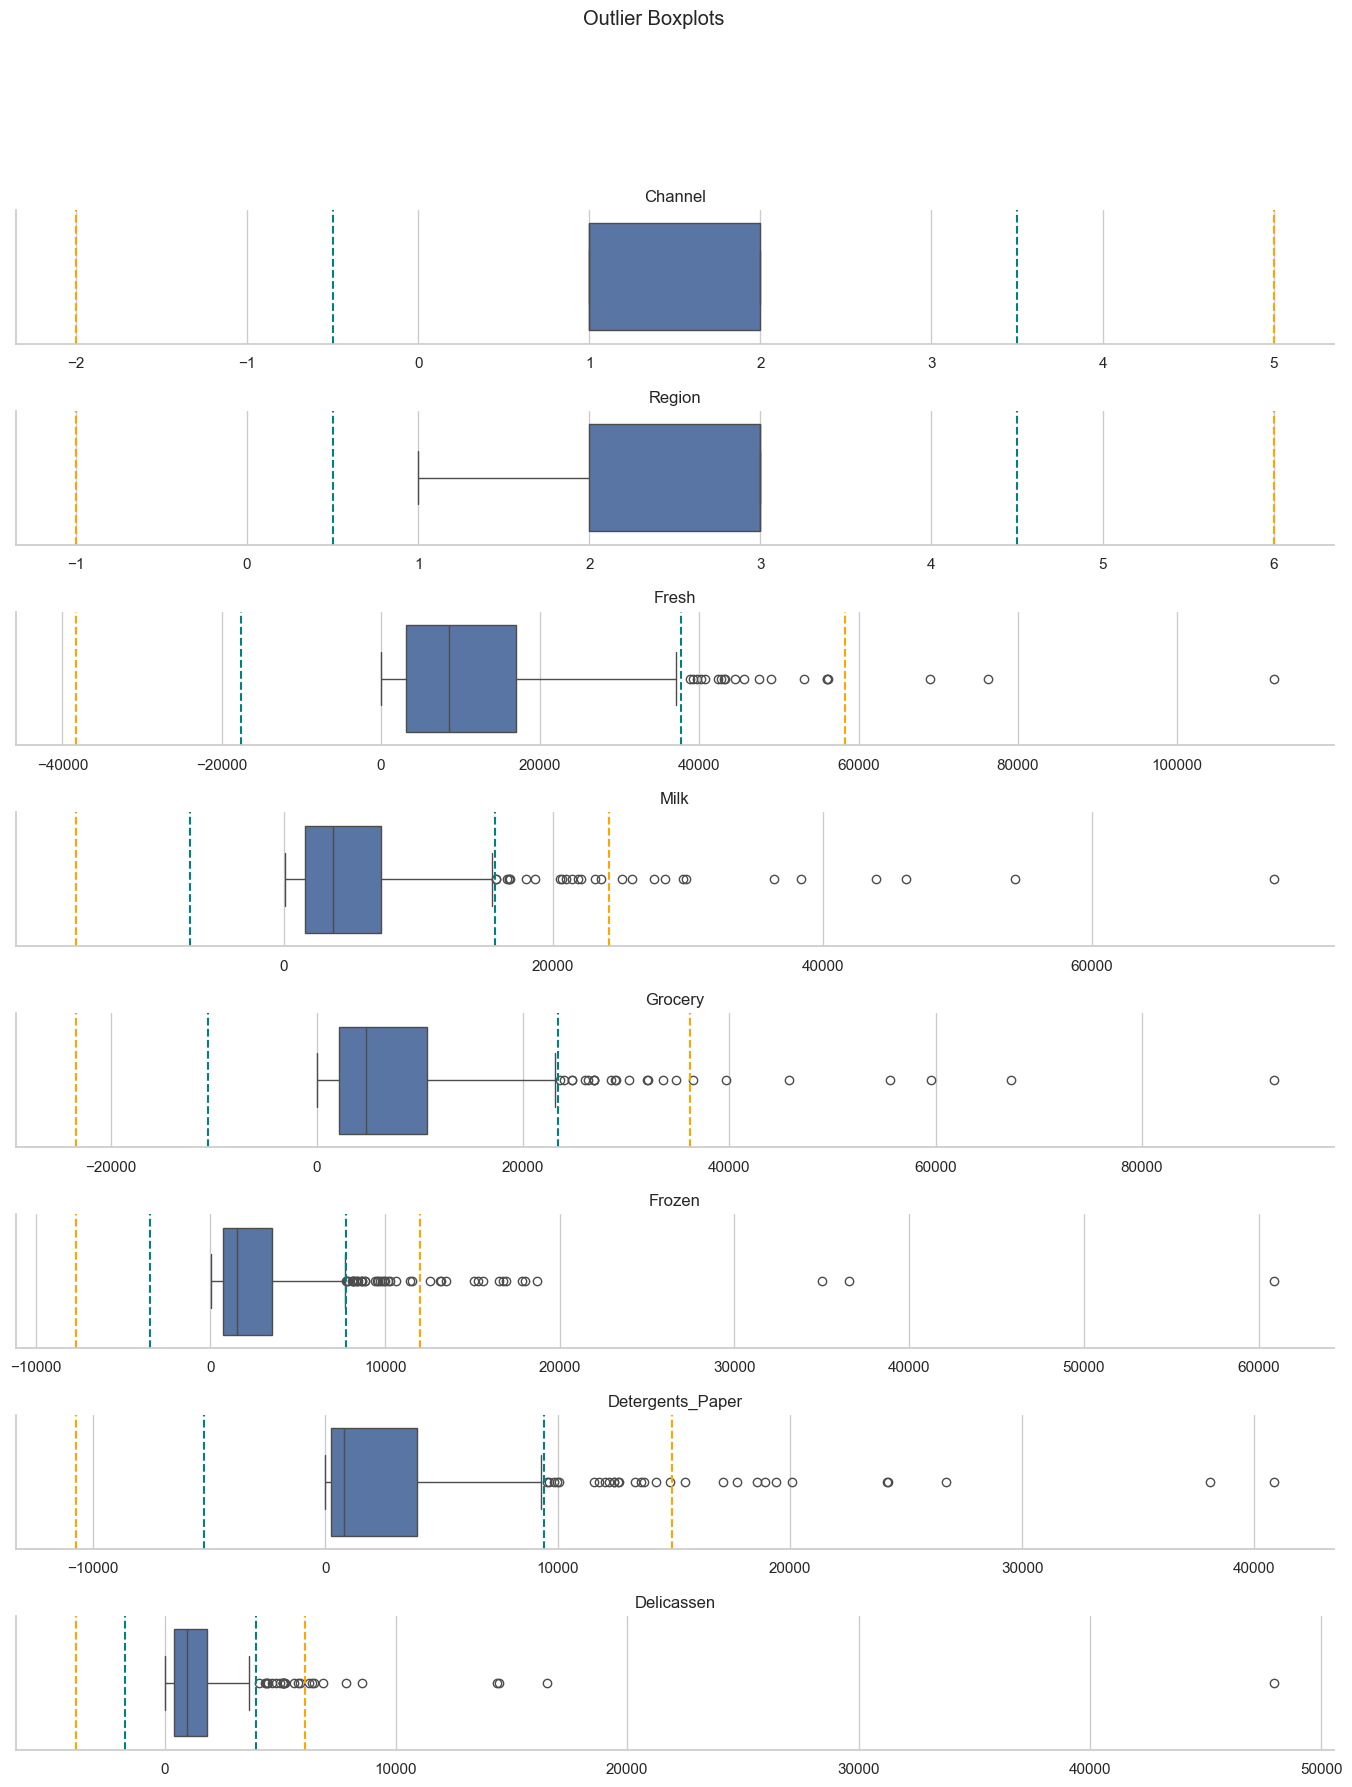

In [11]:
visualize(df, columns, "boxplot", [(17, 20), "Outlier Boxplots", "", ""], False, 1, 0.5)
#Blue Lines: represent the inner fence
# Orange lines: represent the outer fence

In [12]:
continous_columns = df.iloc[:, 2:].columns
df_no_outlier = df.copy()
detect_outliers(df_no_outlier, continous_columns, True)

Fresh [-17581.25, 37642.75] [-38290.25, 58351.75]
The Fresh product has 17 mild outliers and 3 extreme outliers

Milk [-6952.875, 15676.125] [-15438.75, 24162.0]
The Milk product has 16 mild outliers and 12 extreme outliers

Grocery [-10601.125, 23409.875] [-23355.25, 36164.0]
The Grocery product has 17 mild outliers and 7 extreme outliers

Frozen [-3475.75, 7772.25] [-7693.75, 11990.25]
The Frozen product has 27 mild outliers and 16 extreme outliers

Detergents_Paper [-5241.125, 9419.875] [-10739.0, 14917.75]
The Detergents_Paper product has 18 mild outliers and 12 extreme outliers

Delicassen [-1709.75, 3938.25] [-3827.75, 6056.25]
The Delicassen product has 17 mild outliers and 10 extreme outliers



In [13]:
nb_extreme = df_no_outlier[(df_no_outlier["Fresh_extreme"] == True) | (df_no_outlier["Milk_extreme"] == True) | (df_no_outlier["Grocery_extreme"] == True) | (df_no_outlier["Frozen_extreme"] == True) | (df_no_outlier["Delicassen_extreme"] == True) | (df_no_outlier["Detergents_Paper_extreme"] == True)].shape[0]
print(f"There are {nb_extreme} extreme outliers in the dataset.")

There are 38 extreme outliers in the dataset.


- The maximum number of mild oultiers is 112.
- The number of extreme outliers is 38.

**There are only  440 entries in this dataset. As a result, only extreme outliers will be removed.**

In [14]:
def handle_extreme_outliers(dataframe, columns):
    df_outlier = dataframe.copy()
    detect_outliers(df_outlier, columns)
    df_outlier = df_outlier[(df_outlier["Fresh_extreme"] == False) & (df_outlier["Milk_extreme"] == False) & (df_outlier["Grocery_extreme"] == False) & (df_outlier["Frozen_extreme"] == False) & (df_outlier["Delicassen_extreme"] == False) & (df_outlier["Detergents_Paper_extreme"] == False)]
    df_outlier.drop(columns=["Fresh_extreme", "Milk_extreme", "Grocery_extreme", "Frozen_extreme", "Delicassen_extreme", "Detergents_Paper_extreme"], axis=1, inplace=True)
    return df_outlier

In [15]:
df_no_outlier = handle_extreme_outliers(df, continous_columns)

#### Data Transformation:

Even before data visualization, it was deduced that this dataset does not follow a normal distribution as a result, data normalization is a good choice for continous variables.

##### Continous Feature Normalization:

In [16]:
df_normalized = df_no_outlier.copy()
normalizer = MinMaxScaler()
continous_features = df_normalized.iloc[:, 2:].columns
df_normalized[continous_features] = normalizer.fit_transform(df_normalized[continous_features])
df_normalized.head()

Channel  Region     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0        2       3  0.225550  0.409041  0.217253  0.016386          0.180011   
1        2       3  0.125614  0.415602  0.274943  0.150598          0.221728   
3        1       3  0.236164  0.048611  0.121245  0.553061          0.033967   
4        2       3  0.402664  0.228144  0.206818  0.337264          0.119558   
5        2       3  0.167569  0.349523  0.147259  0.055575          0.120771   

   Delicassen  
0    0.227777  
1    0.302508  
3    0.304556  
4    0.884149  
5    0.247057

##### Nominal Features Transformations:
Since the presented categorical variables are nominal, this implies that there is no order between them as a result. Region will be hot encoded and channel will be changed to binary values instead of 1 and 2 to reduce of introducing bias to the models.

**0 -> Horeca**

**1 -> Retail**

In [17]:
#Channel
df_normalized["Channel"] = df_normalized["Channel"].map({1:0, 2:1})

In [18]:
df_normalized["Channel"].value_counts()

Channel
0    278
1    124
Name: count, dtype: int64

In [19]:
df_encoded = pd.get_dummies(df_normalized, columns=["Region"], dtype=int)
df_encoded

Channel     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
0          1  0.225550  0.409041  0.217253  0.016386          0.180011   
1          1  0.125614  0.415602  0.274943  0.150598          0.221728   
3          0  0.236164  0.048611  0.121245  0.553061          0.033967   
4          1  0.402664  0.228144  0.206818  0.337264          0.119558   
5          1  0.167569  0.349523  0.147259  0.055575          0.120771   
..       ...       ...       ...       ...       ...               ...   
434        0  0.297884  0.164749  0.229699  0.057482          0.159590   
436        0  0.698501  0.058623  0.021875  0.388850          0.006066   
437        1  0.258708  0.657507  0.869240  0.035720          1.000000   
438        0  0.183186  0.082055  0.064072  0.087827          0.011120   
439        0  0.049576  0.069998  0.072063  0.003468          0.031945   

     Delicassen  Region_1  Region_2  Region_3  
0      0.227777         0         0         1  
1      0.302508         0         0         1  
3      0.304556         0         0         1  
4      0.884149         0         0         1  
5      0.247057         0         0         1  
..          ...       ...       ...       ...  
434    0.142467         0         0         1  
436    0.399761         0         0         1  
437    0.318034         0         0         1  
438    0.362054         0         0         1  
439    0.008360         0         0         1  

[402 rows x 10 columns]

## 1.2. Data Visualization

* The distribution of features visuazlized
* Correlation heatmap plotted to analyze feature relationships
* Comment on any findings

#### Continous Features Distribution:

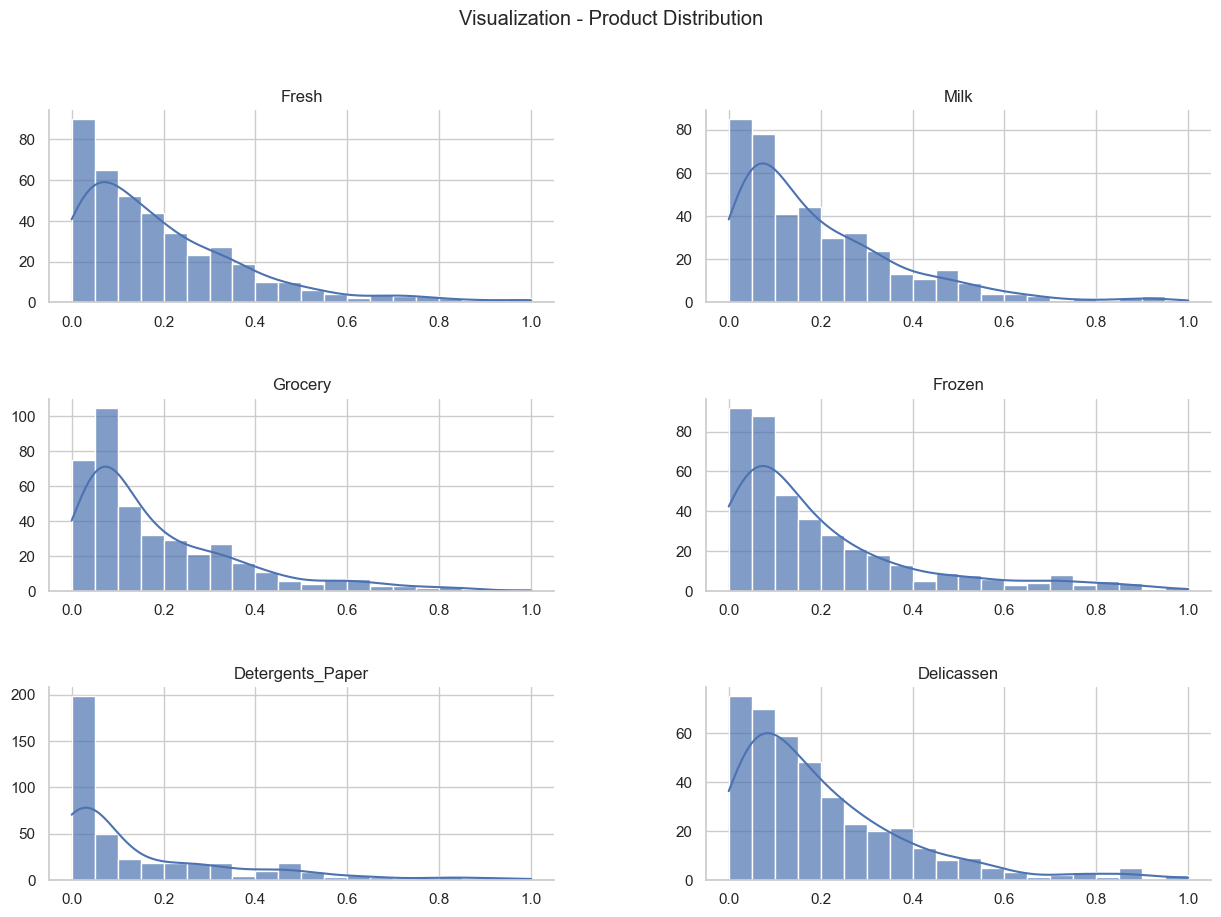

In [20]:
visualize(df_encoded, continous_features, "histplot", info=[(15, 10), "Visualization - Product Distribution", "", ""],h_space=0.5)

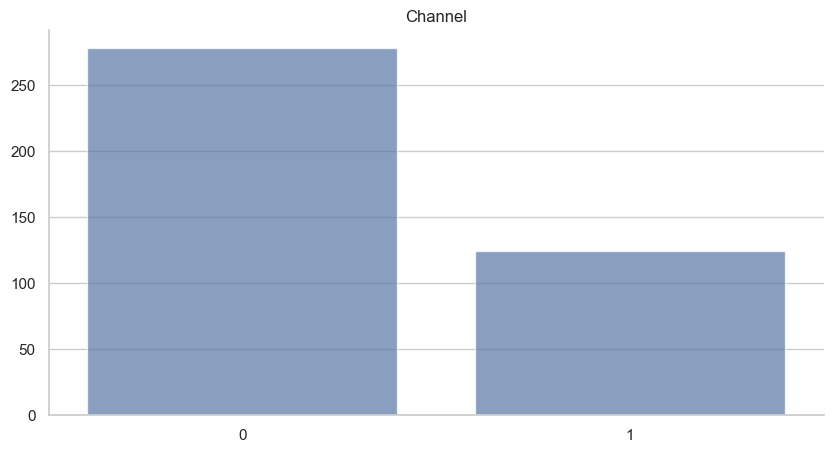

In [21]:
visualize(df_encoded, ["Channel"], "countplot", n_cols=1)

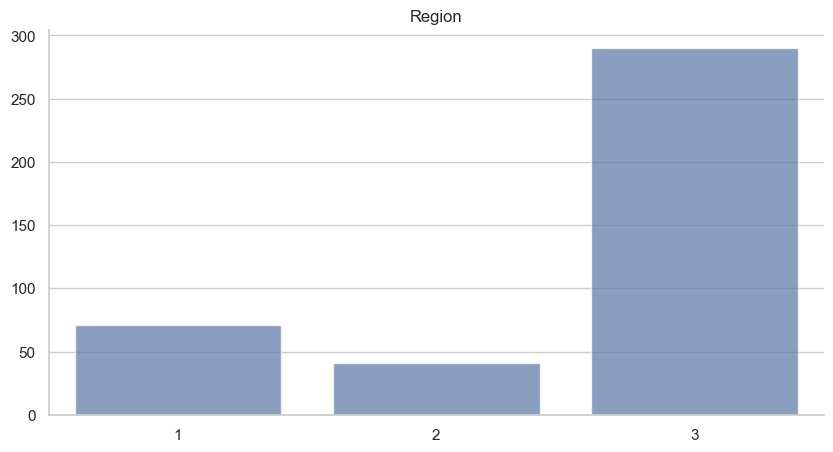

In [22]:
visualize(df_no_outlier, ["Region"], "countplot", n_cols=1)

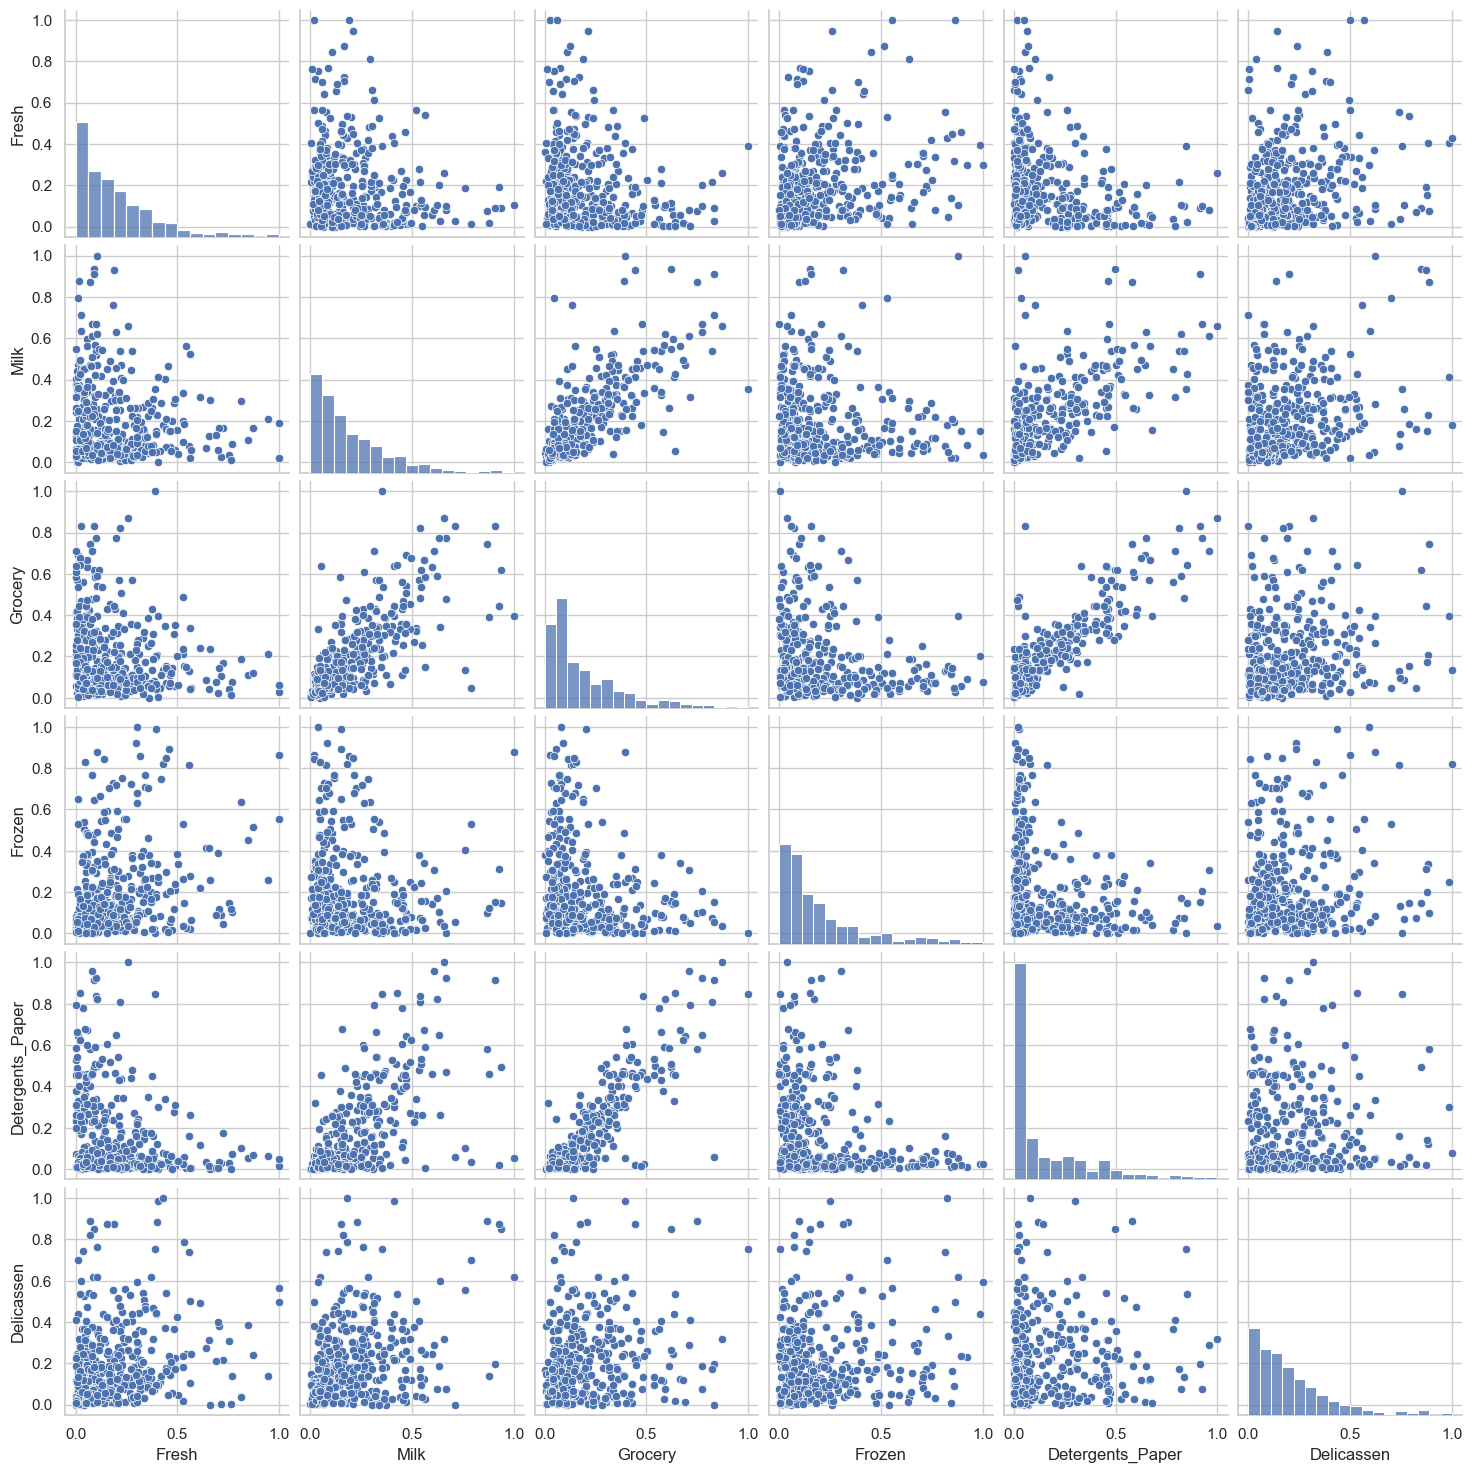

In [23]:
sns.pairplot(data=df_normalized.iloc[:,2:])
plt.show()

#### Relationship between products and channels:

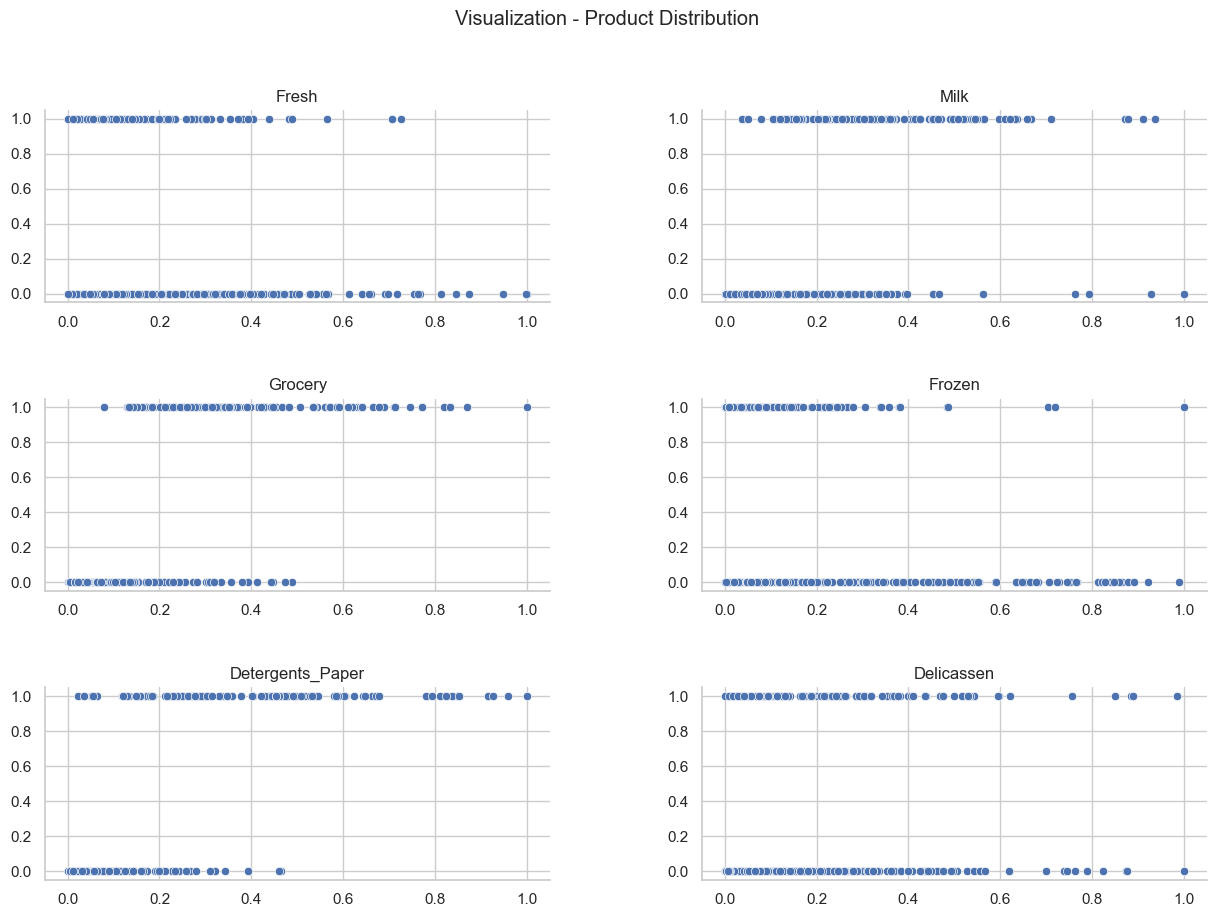

In [24]:
visualize(df_encoded, continous_features, "scatter", info=[(15, 10), "Visualization - Product Distribution", "", ""], target="Channel")

#### Relationship between products and regions:

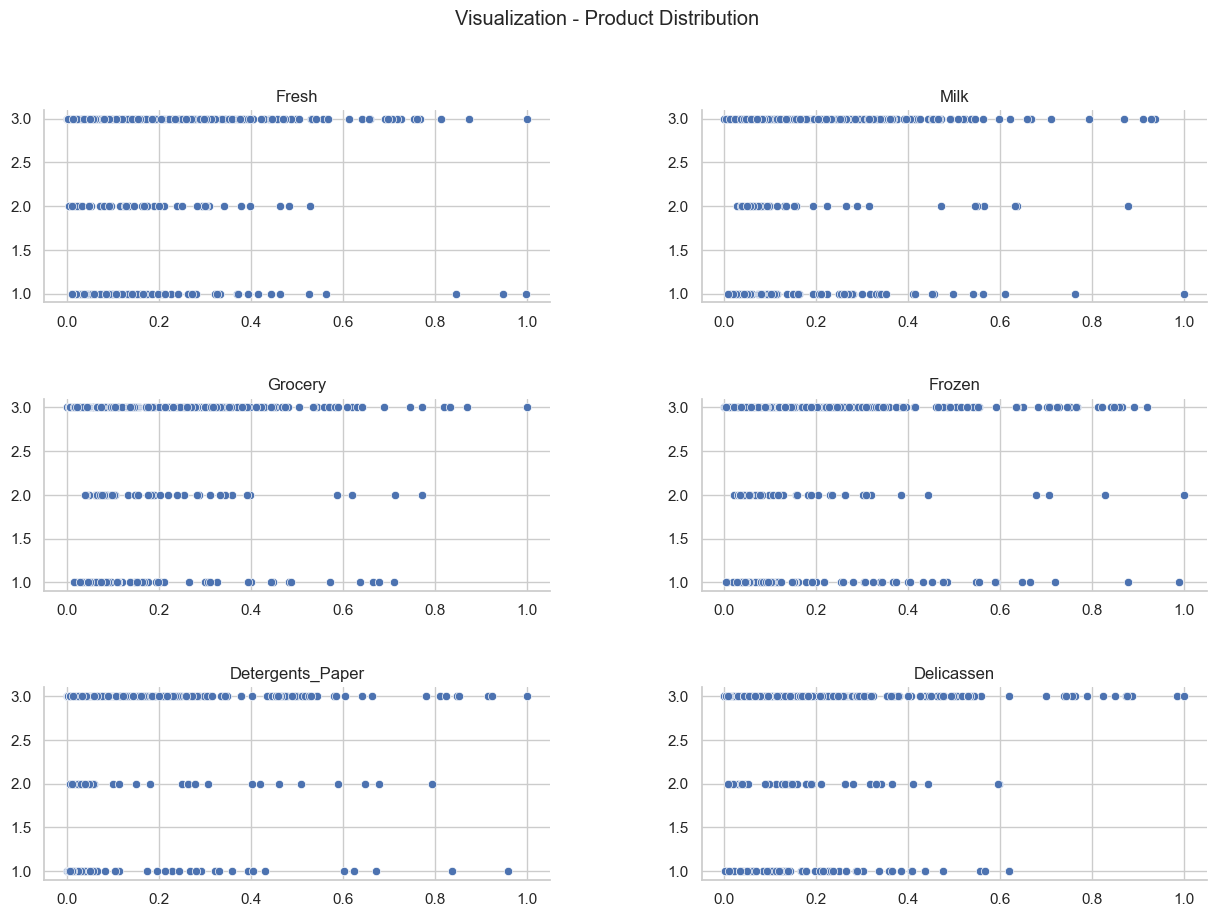

In [25]:
visualize(df_normalized, continous_features, "scatter", info=[(15, 10), "Visualization - Product Distribution", "", ""], target="Region")

#### Correlation heatmap:

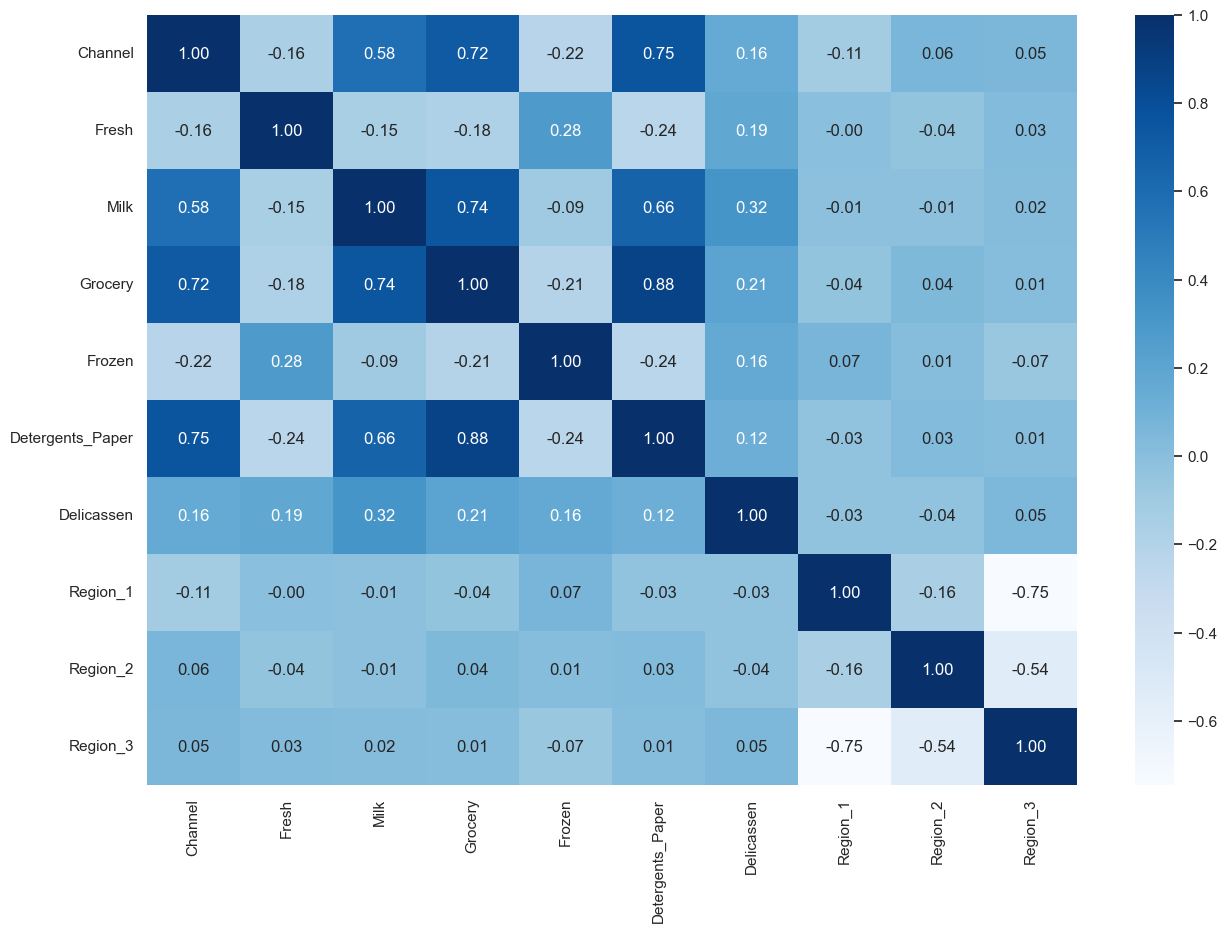

In [26]:
plt.figure(figsize=(15,10))
sns.heatmap(df_encoded.corr(), cmap="Blues", annot=True,fmt=".2f")
plt.show()

#### Analysis & Guesses:
- It is logical to assume which products are the most expensive in this descending order: **Delicassen -> Frozen -> Grocery -> Milk -> Fresh -> Detergents Paper.** Delicassen is the most expensive because it refers to high-quality food such as types of cheese and cold cooked meat often from other countries - *Definition taken from Cambridge Dictionary.*
- Every product is highly positively skewed. Only a minority spends a lot of monetary units for these products.
- Customers from **other regions** mostly spend the most for these products. This cannot give any conclusions to the behavior of such customers in other regions, because this specific value does not define the number of regions it includes. According to the correlation heatmap, there doesn't seem to be a meaningful and informative relationship between these features and the products. **Region will be dropped.**
- **Detergants Papers** are considered to be the cheapest product. As a result, it is reasonable for the distribution to be highly skewed as even high amounts of that product can be relatively cheaper than other products. Only some customers might buy significantly large amounts. **According to the scatter plots, Retail spends the most on Detergants Papers.**
- **Fresh and Frozen products** are bought from **Hareca** more than **retails.** This is due to the high need of these products from cafes, indiviual restaurants, and those in hotels. 0.28 is the correlation between **Fresh and Frozen products.** While it is a low correlation, it is the highest positive correlation that both of these features possess.
- **Milk, Grocery, and Detergant Papers** are bought from **retails** more than **Hareca.** Retails such as shops and markets are considered centers of distribution of these daily-need products. This is supported by the near linear trend the scatter plots exhibit between **Milk and Grocery.** It also seems that as purchases increase for **Grocery** it also somewhat linearly increases for **Detergants Paper.** 0.66 is the correlation between **Detergents_Paper and Milk.** 0.88 is the correlation between **Detergents_Paper and Grocery.** 0.74 is the correlation between **Milk and Grocery.**
- According to the heatmap, there is a small negative correlation between these two groups of products:
  - Group1: Milk, Grocery, and Detergant Papers.
  - Group2: Frozen and Fresh.
- **Delicassen** is evenly bought from both channels. Furthermore, this is deduced from the scatterplots and the close positive correlation values between **Delicassen** and every other product.

**Conclusion**: 
- **The positive skewness of this data can be explained by the natural economic trends of the world. Not all customers will spend large amounts of money on products.**
- **It is plausible to deduce that there are two groups or clusters in this dataset. There are customers who highly buy products of group1 and others who are interested in products of group2. Both channels still buy products from both groups. The guess here is that the optimal number of clusters can be k = 2.**
- **The aim for clustering here is to check which customers buy which products the most. It analyzes the pattern and behavior of the customers towards the products. As a result, Channel should be kept.**

# **PART- 2: Clustering on the Original Dataset**



In [27]:
X = df_normalized.drop(columns=["Region"]).copy()
X_kmean = X.copy()
X_hac=  X.copy()

## 2.1 K-Means Clustering on the Original Dataset

* Chose the optimal k using the Elbow method. Then, visualized the resulting clusters with that k.


In [28]:
# your code here
def optimal_k(dataframe):
    inertia = []
    k_s = range(1, 11)
    for k in k_s:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        kmeans.fit(dataframe)
        inertia.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 6)) 
    sns.lineplot(x=k_s, y=inertia, marker="o") 
    plt.title("Optimal K - Elbow Method") 
    plt.xlabel('K - Number of Clusters') 
    plt.ylabel('Inertia - Sum of Squared Distances')
    plt.show()

C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:13

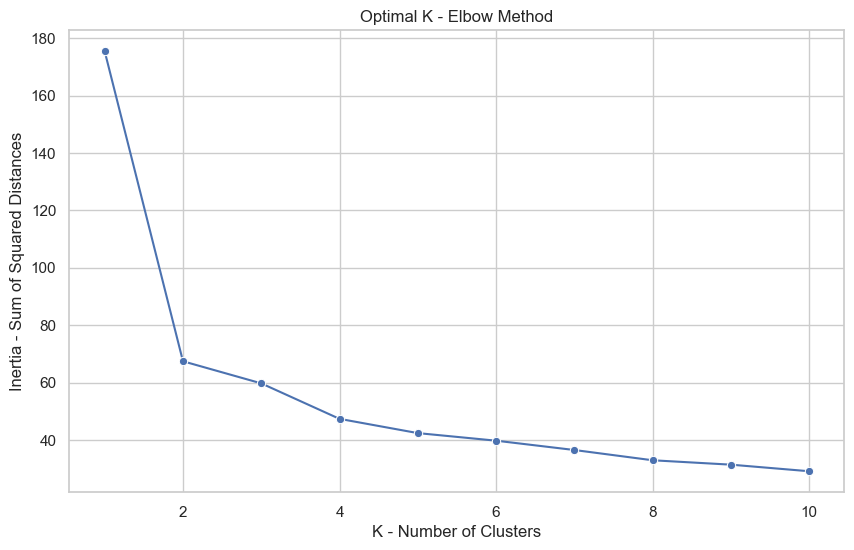

In [29]:
optimal_k(X_kmean)

**Optimal k = 2**

In [30]:
def kmean(dataframe, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(dataframe)
    dataframe["Cluster"] = clusters

In [31]:
kmean(X_kmean, 2)

C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [32]:
print(silhouette_score(X_kmean.drop(columns=["Cluster"]), X_kmean["Cluster"]))

0.5902527622914404


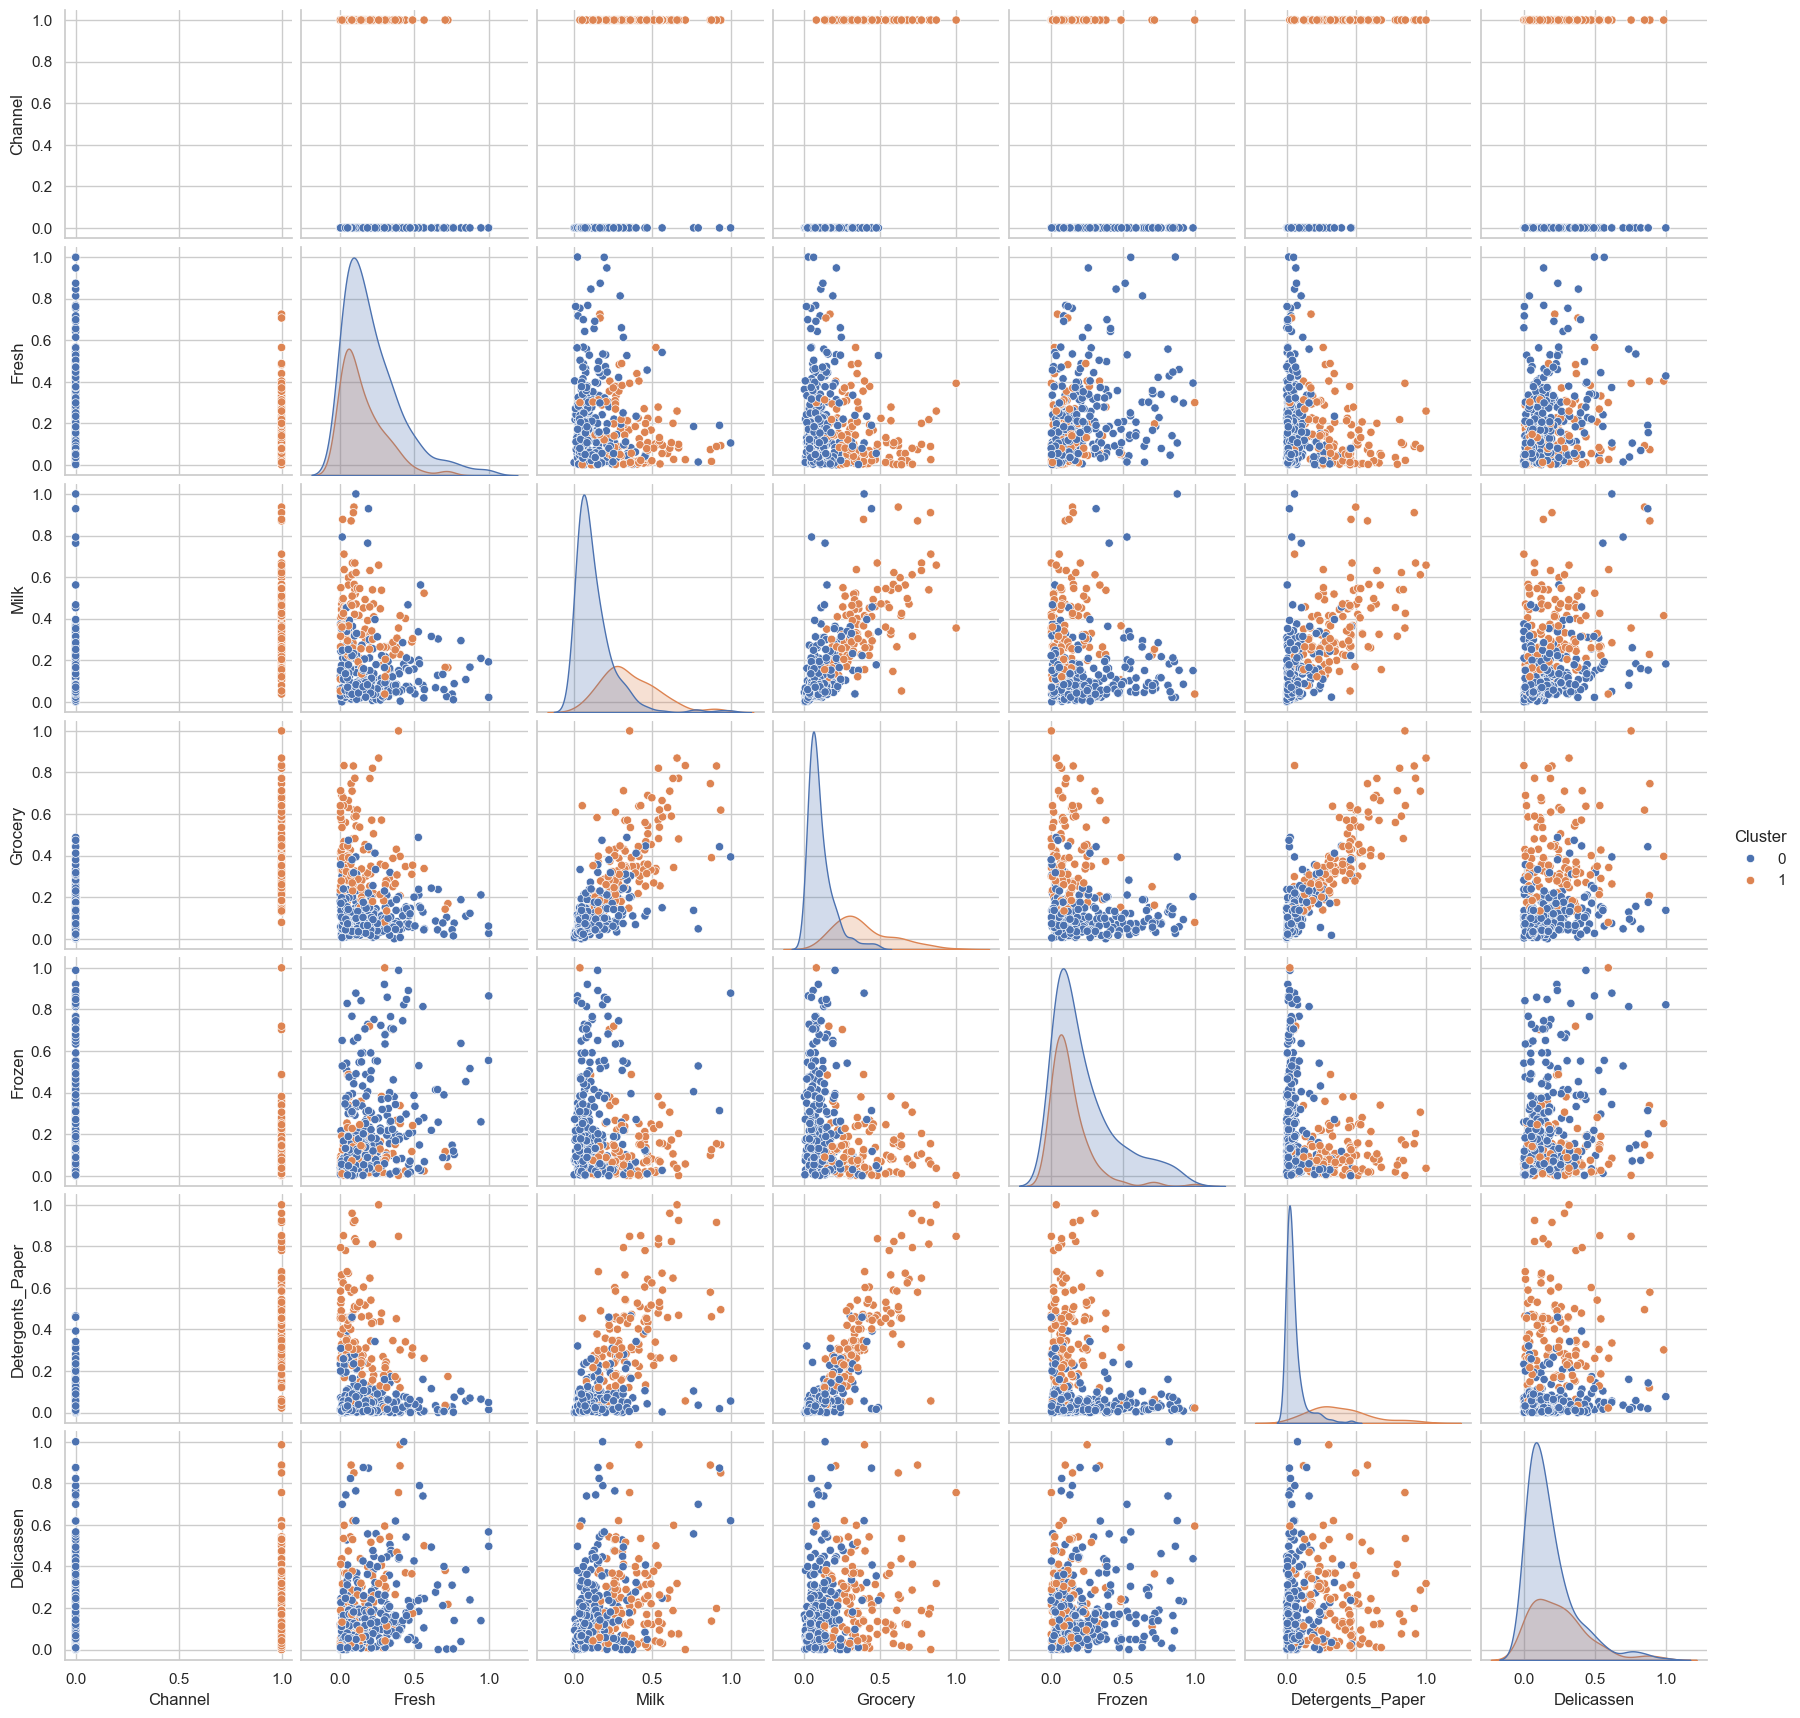

In [33]:
sns.pairplot(X_kmean, hue='Cluster')
plt.show()

## 2.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

* Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

In [34]:
def ward_linkage(X):    
    ward_linkage = hierarchy.linkage(X, 'ward')
    return ward_linkage

def complete_linkage(X):
    complete_linkage = hierarchy.linkage(X, 'complete')
    return complete_linkage

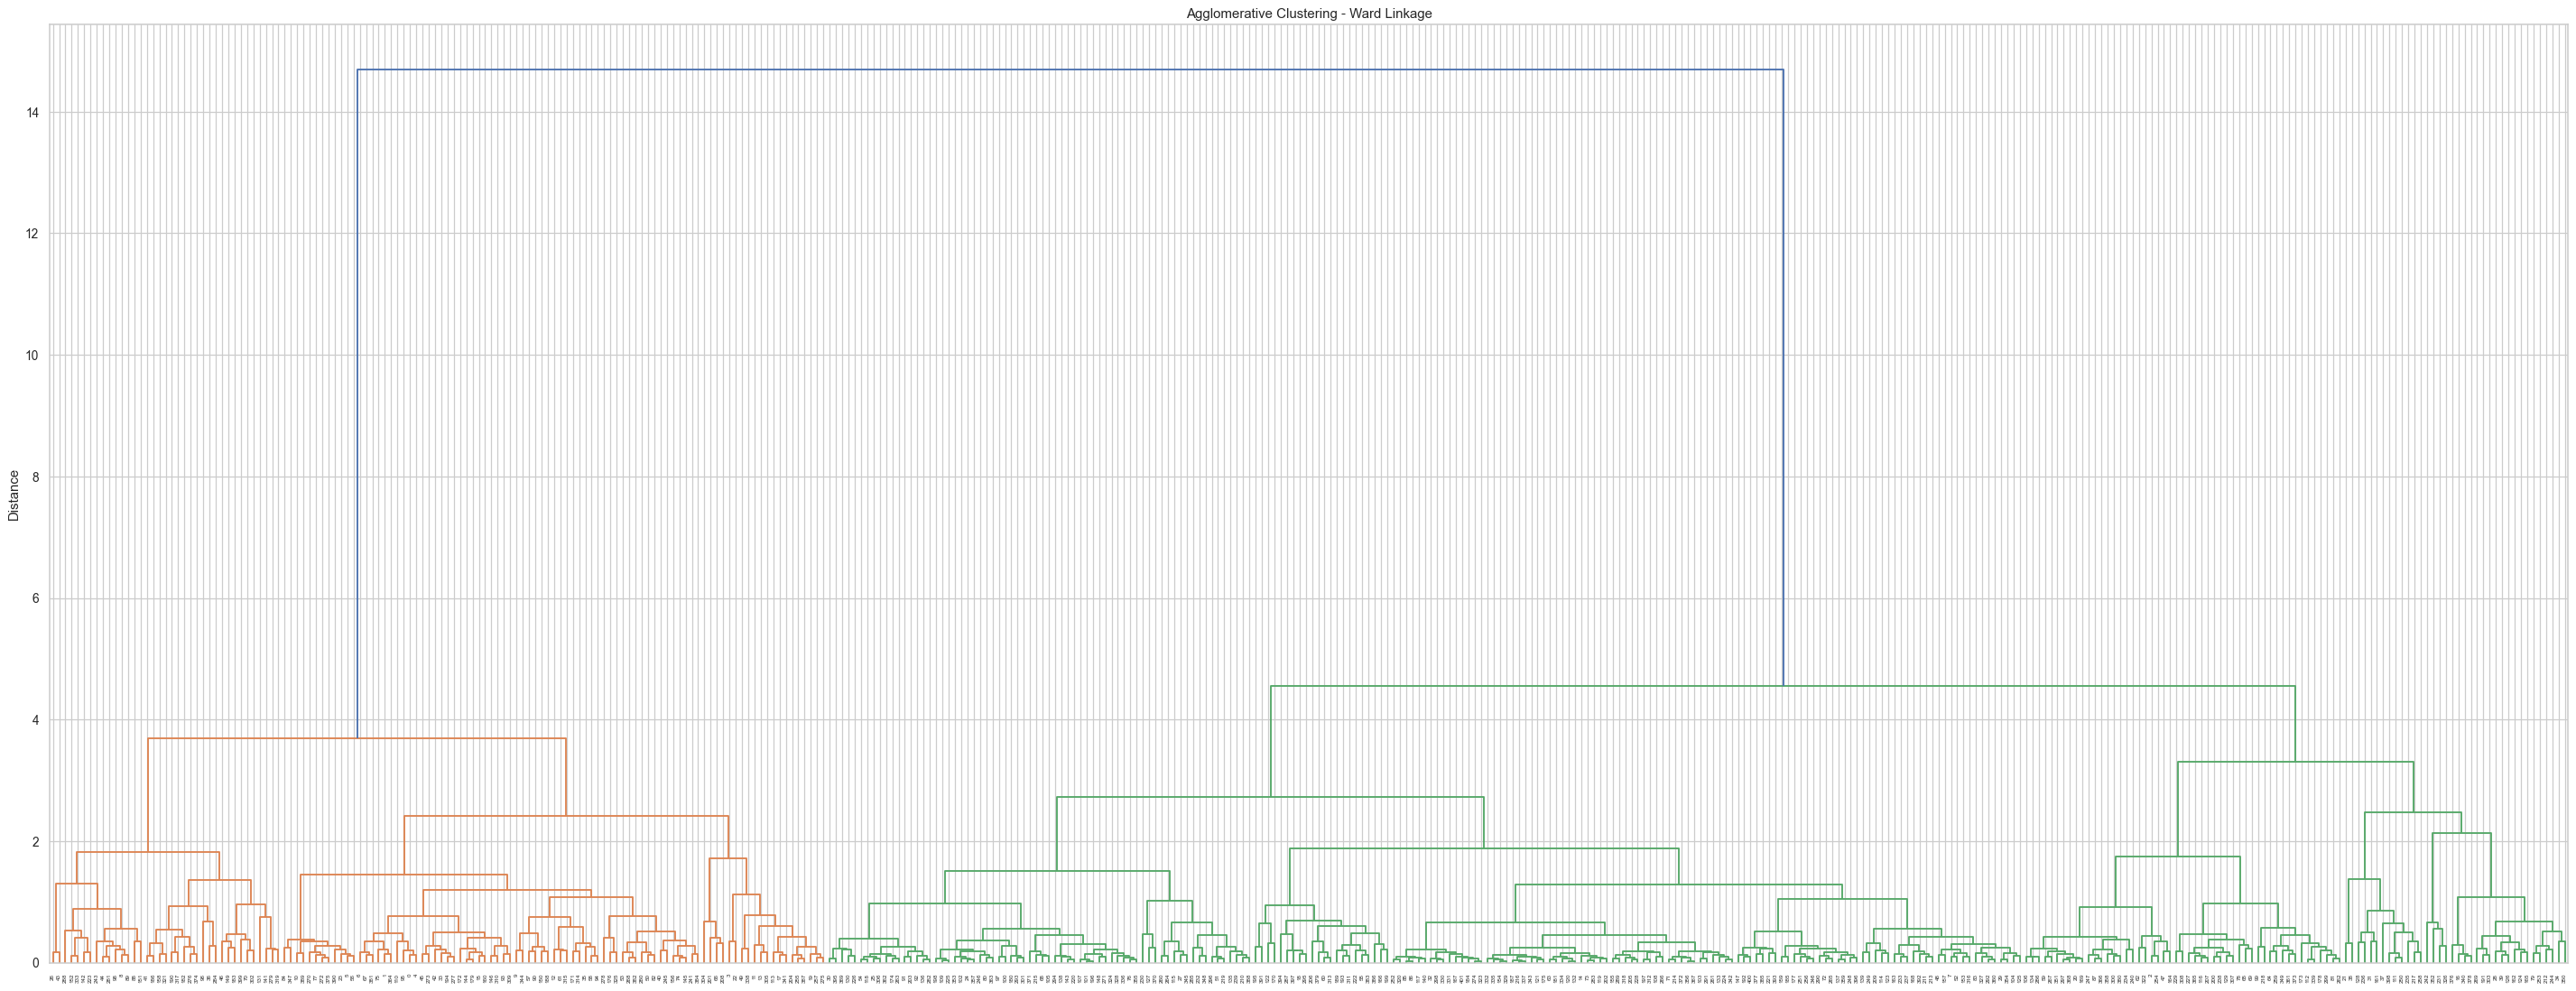

In [35]:
ward_link = ward_linkage(X_hac)
plt.figure(figsize=(40,15), dpi=90)
plt.title("Agglomerative Clustering - Ward Linkage")
plt.ylabel("Distance")
dn_ward = hierarchy.dendrogram(ward_link)

**Optimal clusters for ward linkage k = 2**

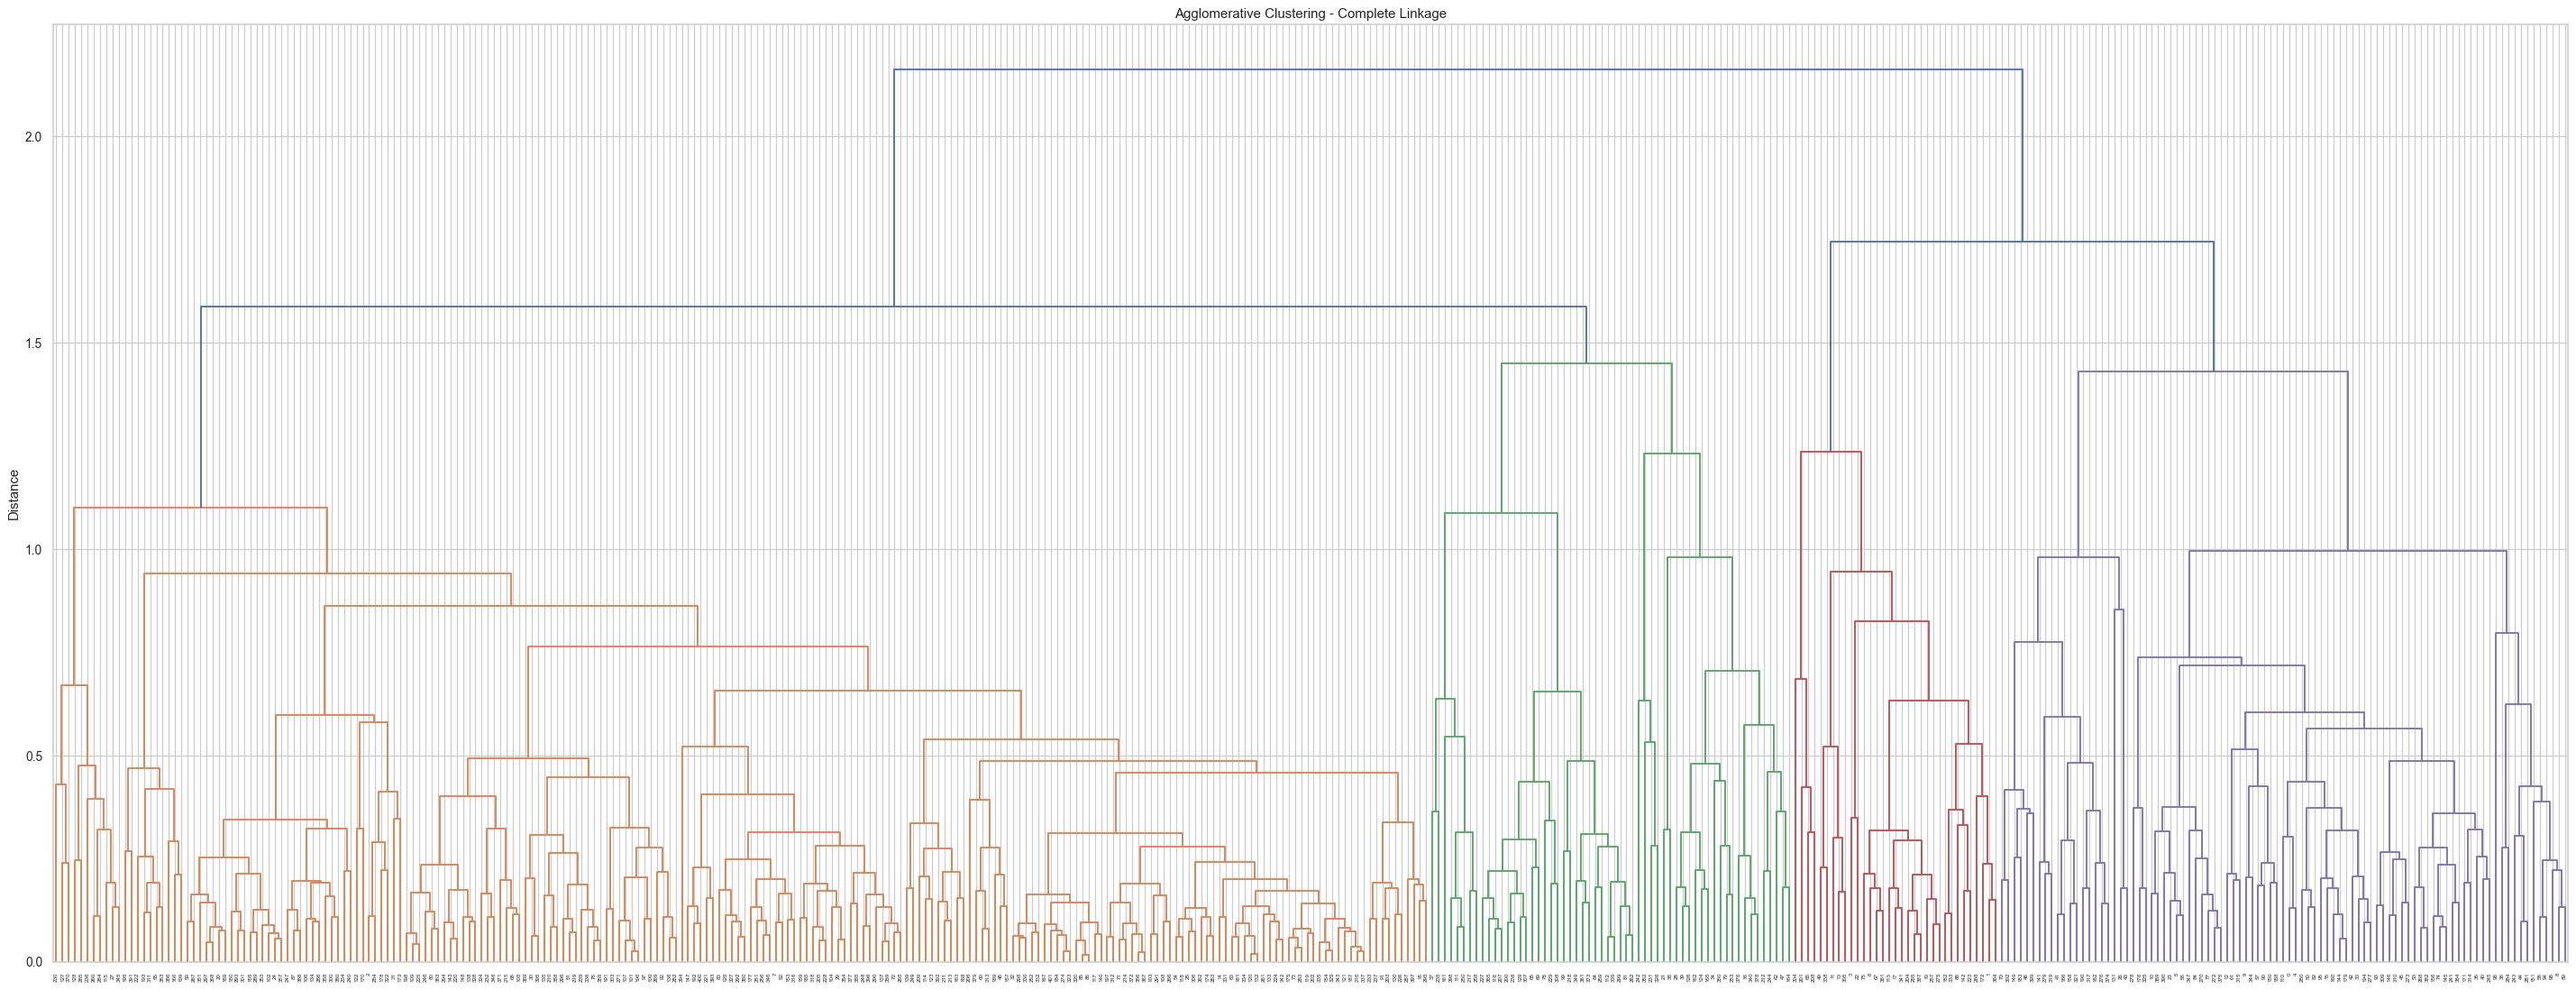

In [36]:
complete_link = complete_linkage(X_hac)
plt.figure(figsize=(40,15), dpi=90)
plt.title("Agglomerative Clustering - Complete Linkage")
plt.ylabel("Distance")
dn_complete = hierarchy.dendrogram(complete_link)

**Optimal clusters for complete linkage k = 4**

Two big clusters and Two minority clusters

In [37]:
def agglomerative_clustering(dataframe, linkage, n_clusters):
    hac = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)  
    hac.fit(dataframe)
    df_agglo = dataframe.copy()
    df_agglo["Cluster"] = hac.labels_
    return df_agglo

#### Ward Linkage:

In [38]:
X_ward = agglomerative_clustering(X_hac, "ward", n_clusters=2)

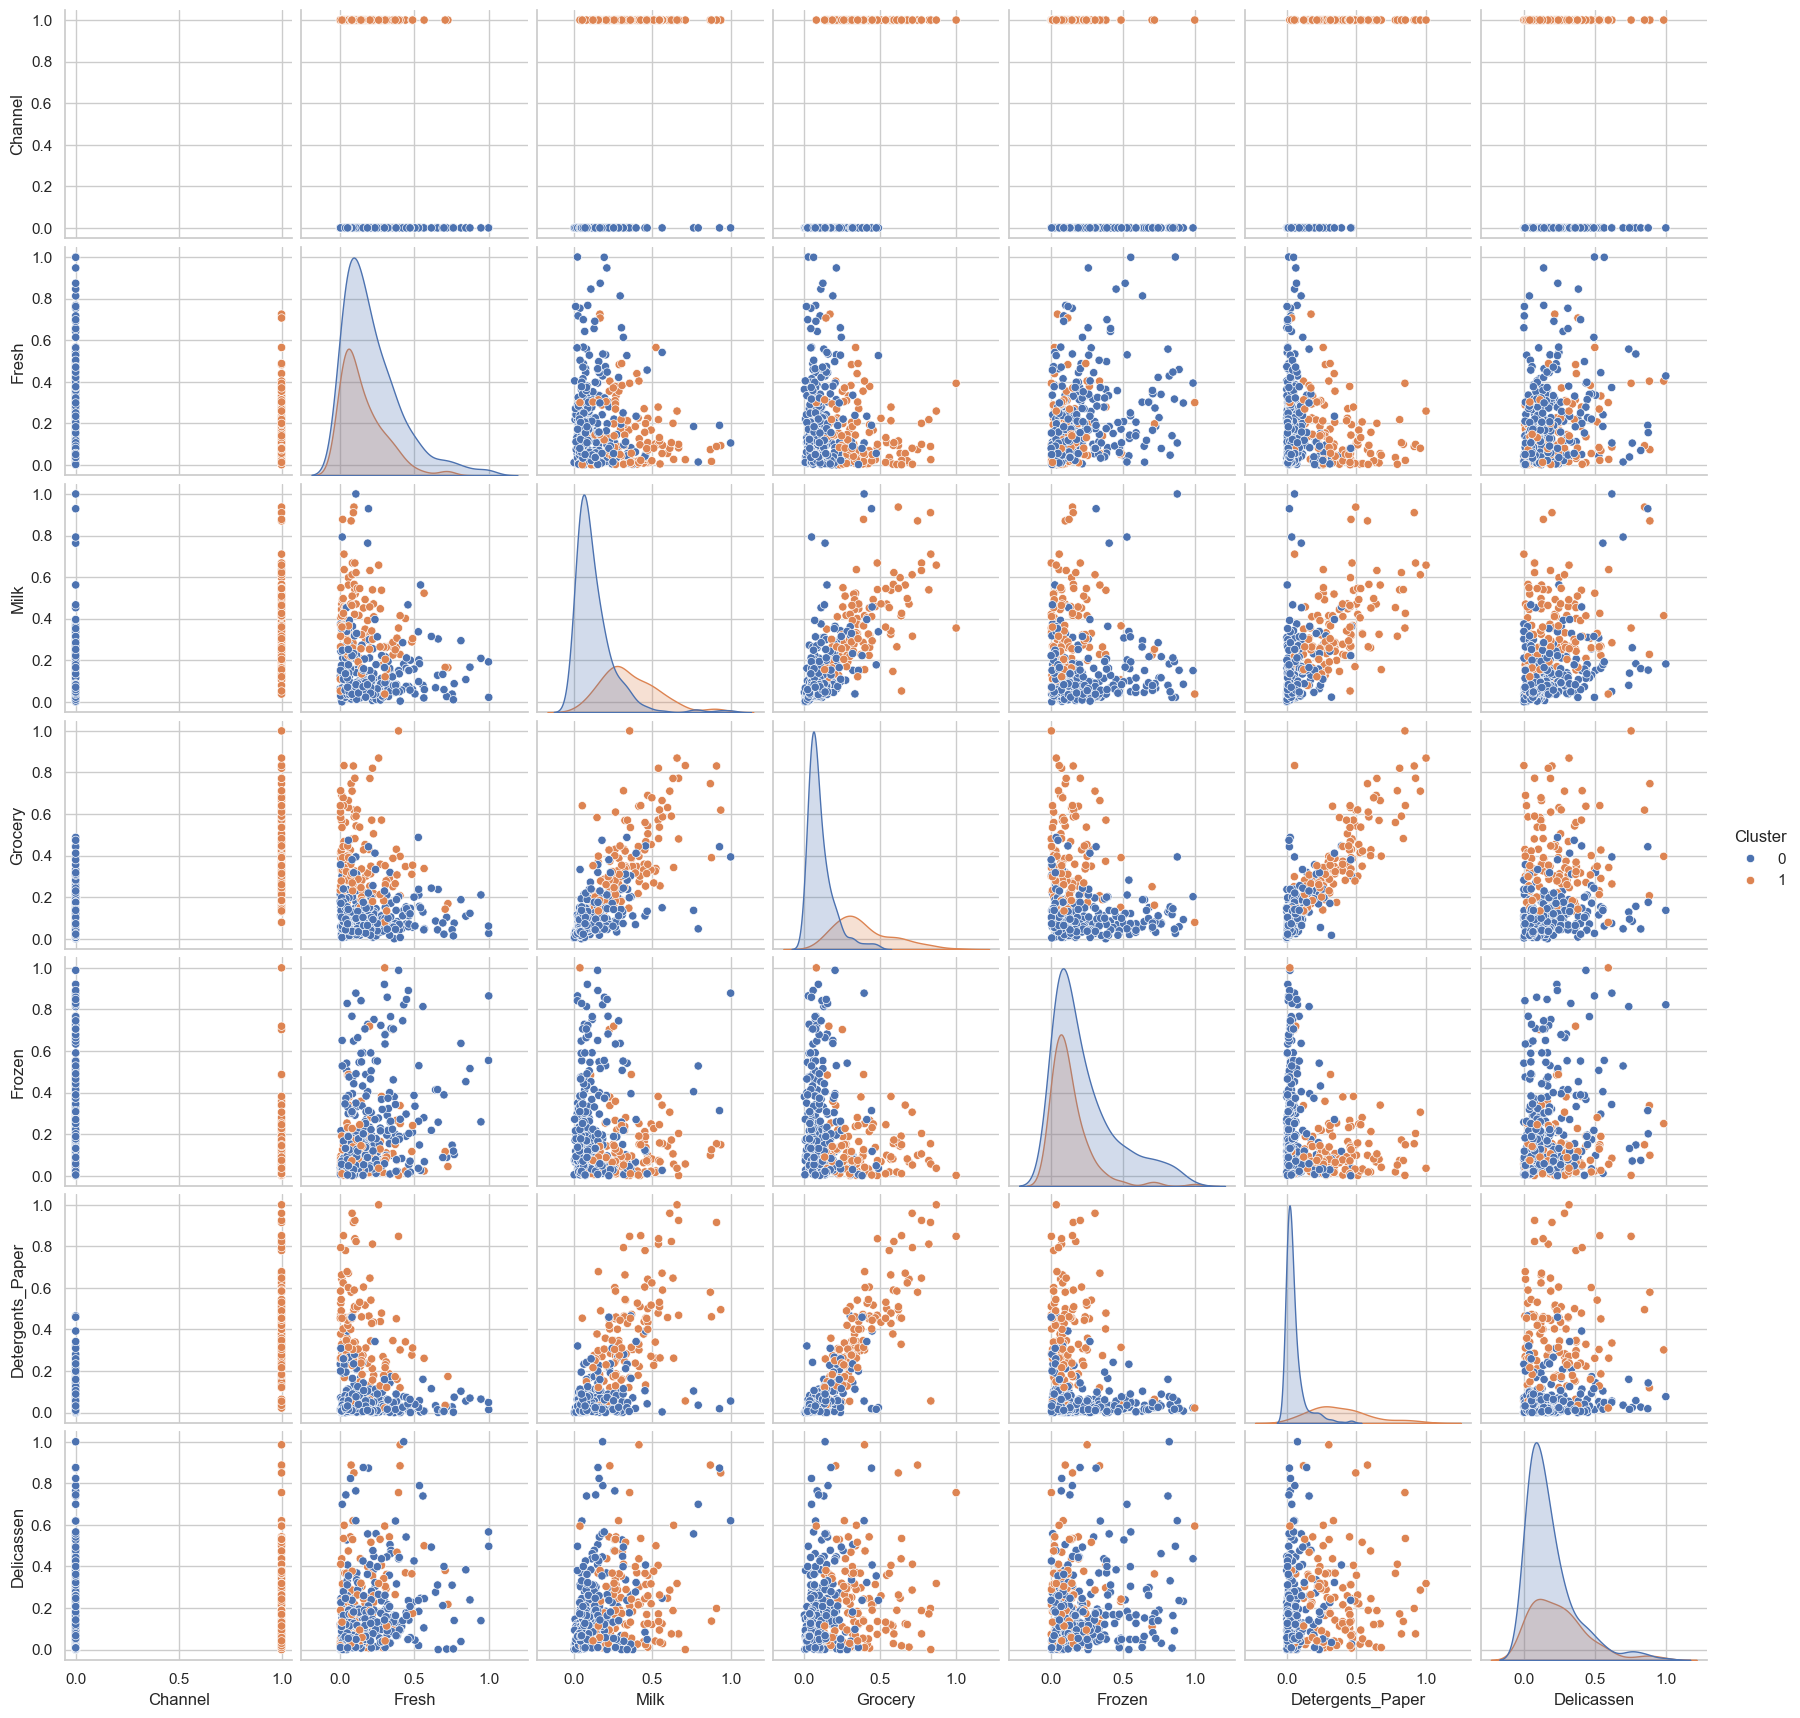

In [39]:
sns.pairplot(X_ward, hue='Cluster')
plt.show()

In [40]:
print("Silhouette Score for Agglomerative Clustering - Ward Linkage:",silhouette_score(X_ward.drop(columns=["Cluster"], axis=1), X_ward["Cluster"]))

Silhouette Score for Agglomerative Clustering - Ward Linkage: 0.5902527622914404


#### Complete Linkage:

In [41]:
X_complete = agglomerative_clustering(X_hac, "complete", n_clusters=4)

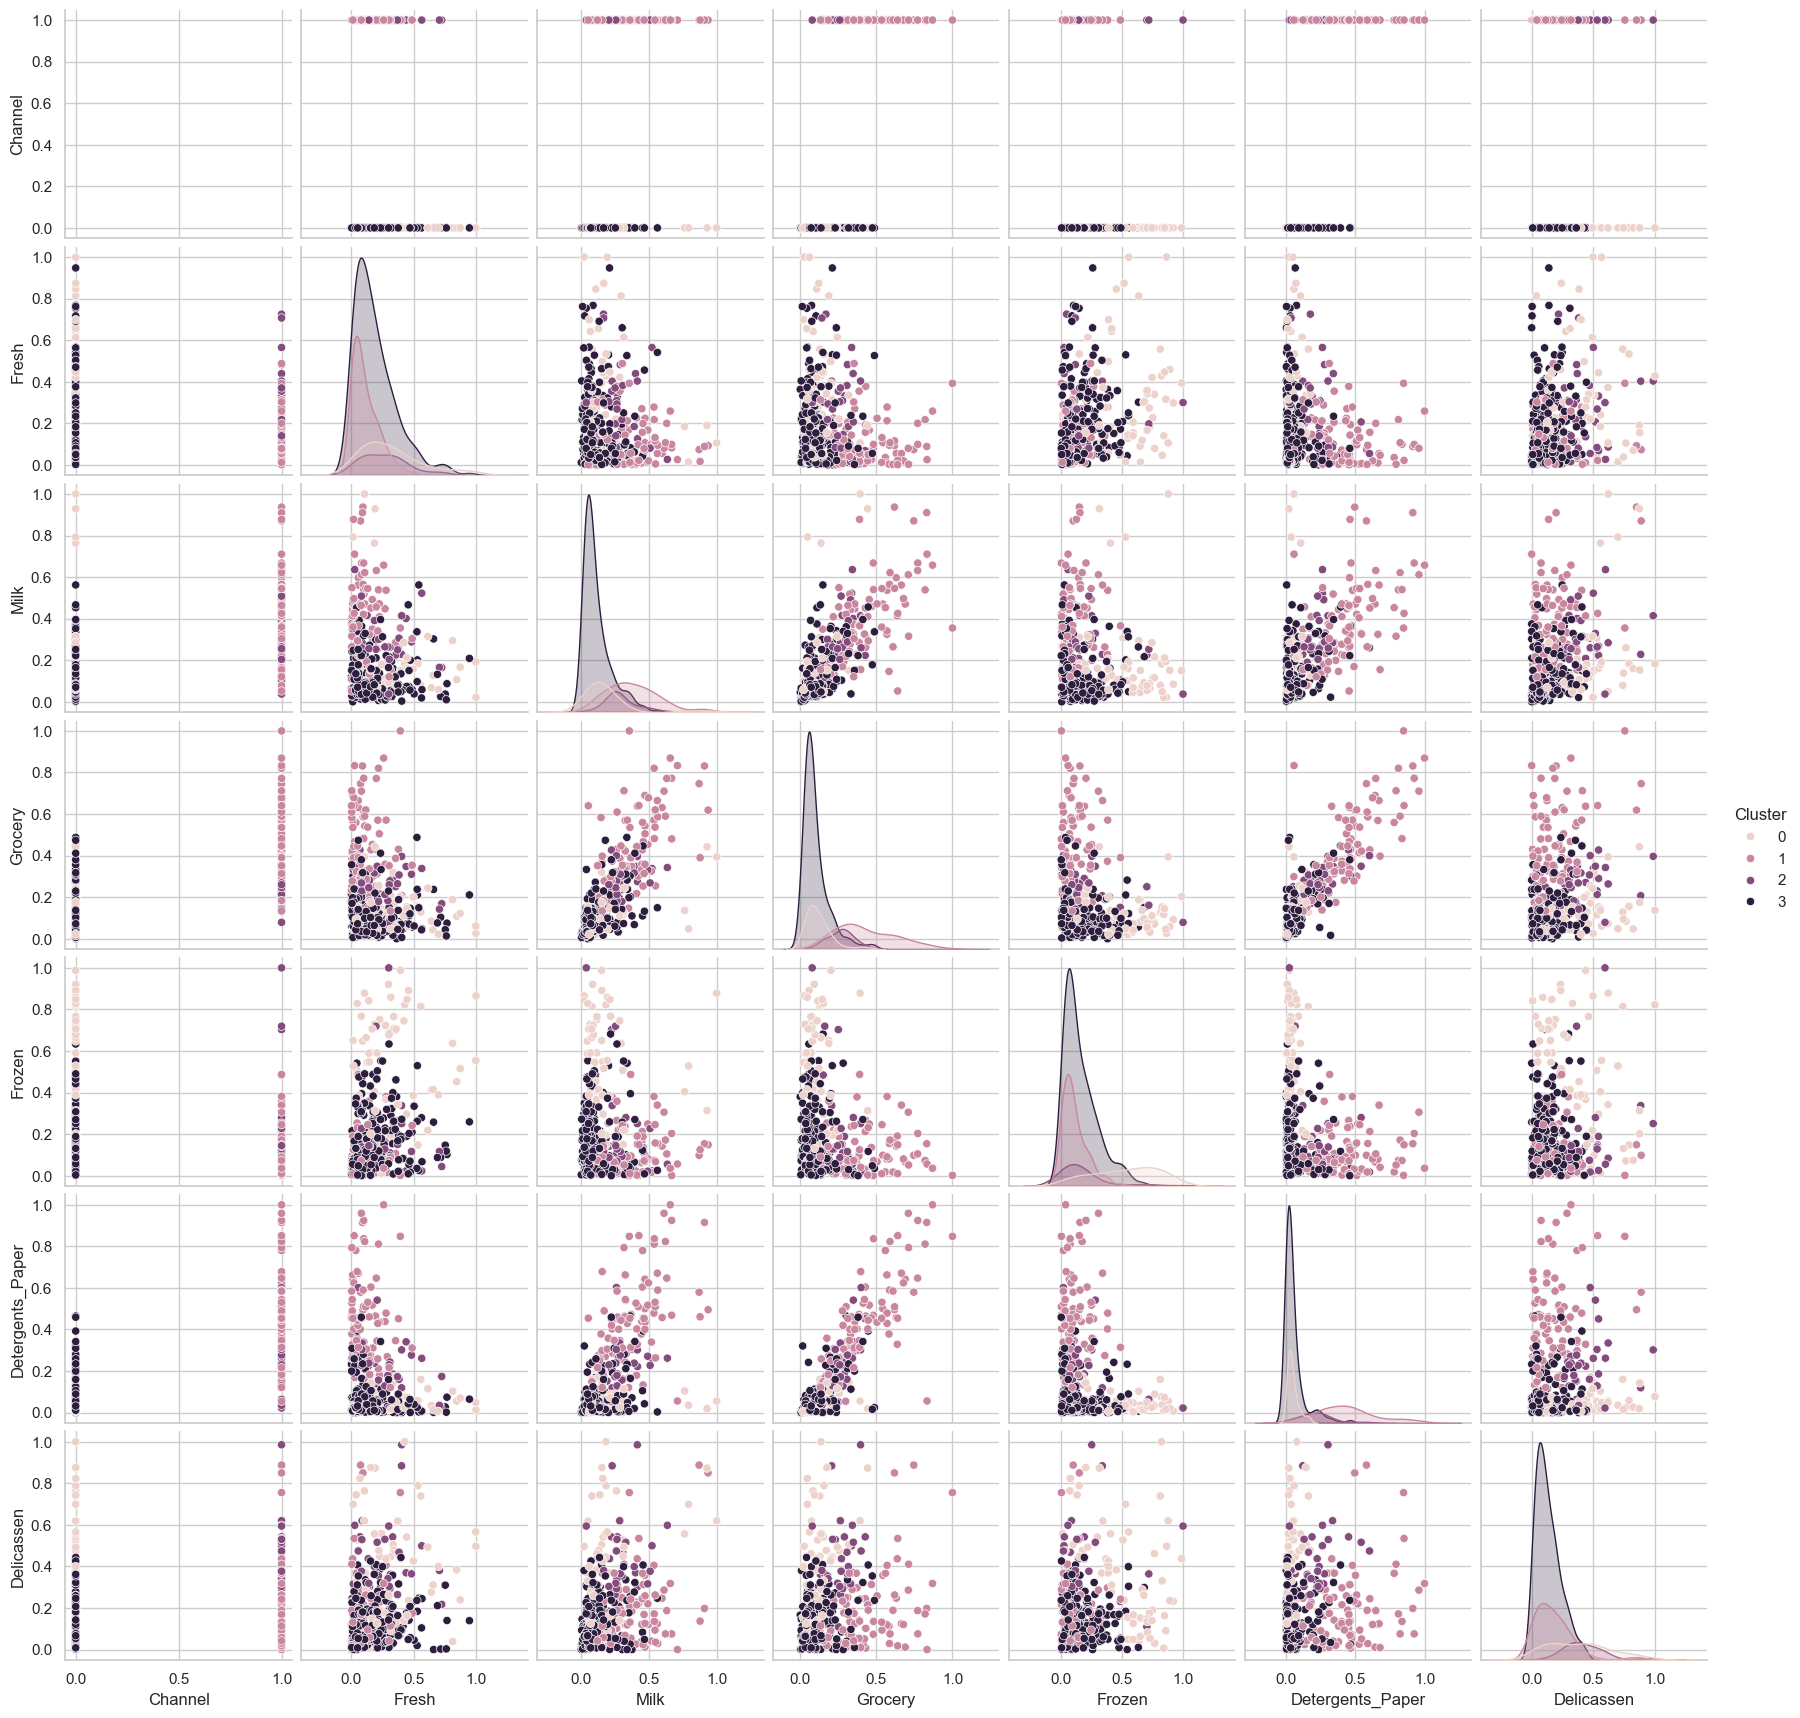

In [42]:
sns.pairplot(X_complete, hue='Cluster')
plt.show()

In [43]:
print("Silhouette score for Agglomerative Clustering - Complete Linkage:",silhouette_score(X_complete.drop(columns=["Cluster"], axis=1), X_complete["Cluster"]))

Silhouette score for Agglomerative Clustering - Complete Linkage: 0.31898342141690617


#### Analysis:
- As previously guessed the optimal number of clusters was 2.
- Both kmean clusters and Agglomerative Clustering with ward linkage performed the same yieldin the same silhouette score: 0.59. Ward linkage was able to perform better than the complete linkage. Ward linkage minimizes the variance when grouping data points to clusters making them less spread and more compact while complete linkage minimizes the maximum distances of points within different clusters. With complete linkage, it is more likely to have far points clustered together than using Ward linkage.
- The complete linkage of the Agglomerative Clustering algorithm had 4 clusters instead of 2. While there was 3 main clusters dominating and one minority cluster, it was not able to be fully in accordance with kmeans.

# **PART- 3: Dimensionality Reduction**




## 3.1. Apply PCA

In [44]:
# Normalize the data - Done
df_pca = df_normalized.drop(columns=["Region"]).copy()

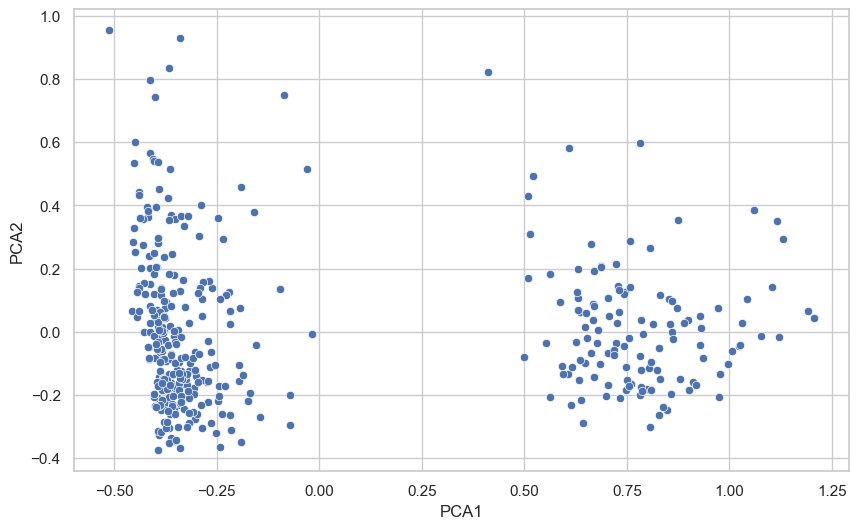

In [45]:
pca = PCA() 
pca_components = pca.fit_transform(df_pca) 
df_pca['PCA1'] = pca_components[:, 0] 
df_pca['PCA2'] = pca_components[:, 1] # Plotting the clusters 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2')
plt.show()

There are two clusters

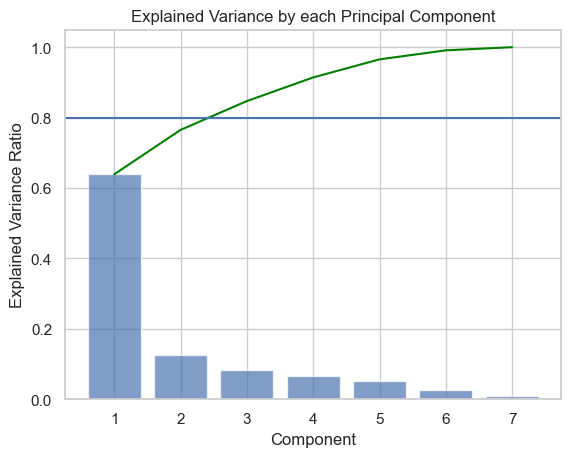

In [46]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1,len(cumulative_variance) + 1), cumulative_variance, label="test", color="green")
plt.axhline(y=0.8)
plt.title("Explained Variance by each Principal Component")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

According to this graph, the first two components capture about 80% of the data. The first two components are enough.

## 3.2. K-means Clustering with PCA

C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:13

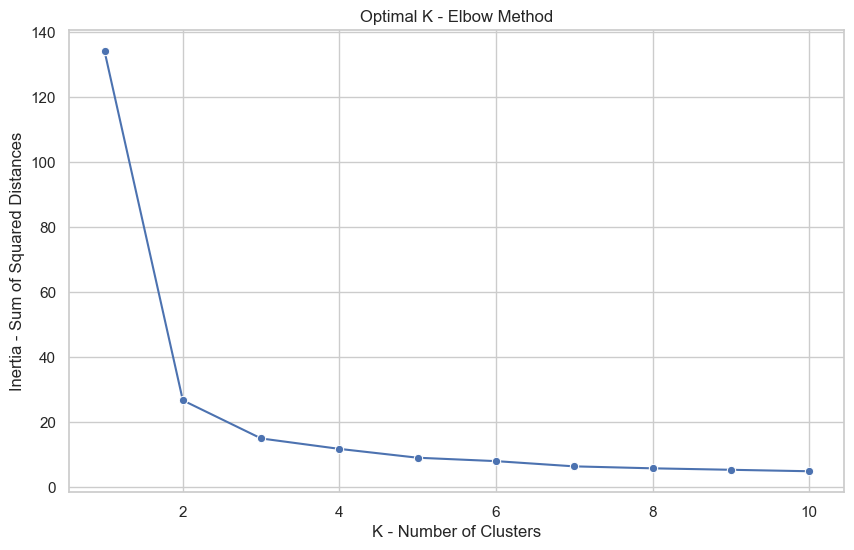

In [47]:
# your code here
df_pca = df_pca[["PCA1","PCA2"]]
optimal_k(df_pca)

In [48]:
kmean(df_pca, 2)

C:\Users\Manso\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


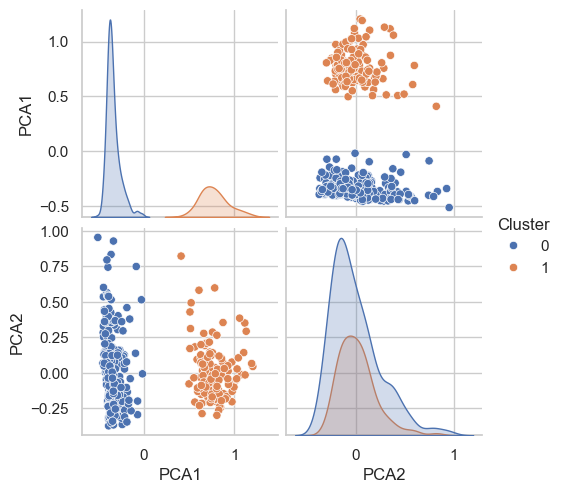

In [49]:
sns.pairplot(df_pca, hue='Cluster')
plt.show()


# **PART- 4: Evaluate the Clustering Results**

In [50]:
# your code here
k_score = silhouette_score(X_kmean.drop(columns=["Cluster"], axis=1), X_kmean["Cluster"])
pca_score = silhouette_score(df_pca.drop(columns=["Cluster"], axis=1), df_pca["Cluster"])
print("Silhouette score for the k means without PCA:",k_score)
print("Silhouette score for the k means with PCA", pca_score)

Silhouette score for the k means without PCA: 0.5902527622914404
Silhouette score for the k means with PCA 0.743949471554013


- The Silhouettte score for the kmeans without Dimensionality reduction (PCA) was 0.59, significantly lower than that with PCA with score 0.74. But kmeans without PCA produced a moderate clustering result.

-  According to the scatterplot of the kmeans, the data was not well-clustered and not seperated from each other. On the other hand, the kmeans with PCA was effective in identifying the clustering and seperating them accordingly.

-  Silhouette score for agglomerative clustering with ward linkage was 0.59 and with complete linkage was 0.32. **Generally speaking, Kmeans was a better clustering method than agglomerative clustering with complete linkage and performed the same with ward linkage for this dataset.**
-  **The PCA-reduced dataset resulted in the best clustering than the original dataset.**

- **PCA was able to mitigate the curse of dimensionality which helped kmeans perform more efficiently. PCA was able to preserve 80% of the dataset so the noise and unecessary data was reduced and the kmeans was able to distinguish between the data more effectively yielding more compact and less spread clusters. PCA might lead to some distortions as well since it is a linear transformation. While some of our data had linear relationships, there was some non-linear trends which might be a hypothesis for not having a better silhouette score.**

- **Kmeans was computationally less expensive that Agglomerative clustering. With kmeans, the clusters are determined with distance calculations between data points and centroids(only 2 centroids in this assignment.) However, agglomerative clustering needs to always calculate the distances between points of different clusters.**

# **REFERENCES**
- **Definition of delicatessen from the cambridge dictionary: https://dictionary.cambridge.org/dictionary/english/delicatessen**
- **Wholesale customers dataste from the UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/292/wholesale+customers**